In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.svm import SVR
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from plotly.offline import plot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import plotly.express as px
import math
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import Hyperparameter
import itertools 
import matplotlib.cm as cm 
from smt.sampling_methods import LHS
import dash
import dash_core_components as dcc
import dash_html_components as html
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import euclidean_distances
from scipy.special import softmax
import time


def function(x1,x2):
    y= np.cos(x1)*np.cos(x2)*(np.exp(-(x1+2)**2-(x2-2)**2)+0.5*np.exp(-(x1-2)**2-(x2+2)**2))
    return y


def making_Grid(r1,r2,interval):
    x1=np.arange(r1,r2+0.1,interval)
    x2=np.arange(r1,r2+0.1,interval)
    data=pd.DataFrame()
    for i in x1 :
        for z in x2:
            a=[[i,z]]
            data=data.append(a,ignore_index=True)
    data.columns=['x1','x2']
    data['y']=function(data['x1'],data['x2'])

    return data

def making_Random(r1,r2,num):
    x={'x1':np.random.uniform(r1,r2,num).T, 'x2':np.random.uniform(r1,r2,num).T}
    data=pd.DataFrame(x)
    data['y']=function(data['x1'],data['x2'])
    return data

def making_LHS(r1,r2,num):
    xlimits = np.array([[r1, r2], [r1, r2]])
    sampling = LHS(xlimits=xlimits,criterion='ese')
    x = sampling(num)
    data=pd.DataFrame(x,columns=['x1','x2'])
    data['y']=function(data['x1'],data['x2'])
    return data






def select_new_pt(selected_pt): 
    # x1 : [0.1, 0.3]
    # v : [0, 5]
    # c : [0, 0.2]

    Max_L = 6
    Min_L = -6
    Max_v = 6
    Min_v = -6
   

    div_thres = 10
    dist_L = (Max_L - Min_L) / div_thres
    dist_v = (Max_v - Min_v) / div_thres
   
    L_range_min = selected_pt[0] - dist_L
    L_range_max = selected_pt[0] + dist_L
    v_range_min = selected_pt[1] - dist_v
    v_range_max = selected_pt[1] + dist_v


    if L_range_min < Min_L:
        L_range_min = Min_L
    if L_range_max > Max_L:
        L_range_max = Max_L

    if v_range_min < Min_v:
        v_range_min = Min_v
    if v_range_max > Max_v:
        v_range_max = Max_v
    
    return L_range_min, L_range_max, v_range_min, v_range_max

def qbc(X_tr):
    var=[]
    for i in range(len(X_tr)):
        x_loo=X_tr[i:i+1]

        pred1=qbc1.predict(x_loo)
        pred2=qbc2.predict(x_loo)
        pred3=qbc3.predict(x_loo)
        pred4=qbc4.predict(x_loo)
        pred5=qbc5.predict(x_loo)
        p=[pred1,pred2,pred3,pred4,pred5]
        v=np.var(p)
        var.append(v)
    Var=pd.DataFrame(data=var,columns=['var'])
    var_df=pd.merge(X_tr,Var,left_index=True,right_index=True)
    
    var_df['probability']=var_df['var']/sum(var_df['var'])
    var_df['p_root']=(var_df['var']/sum(var_df['var']))**0.5
    var_df['p_square']=(var_df['var']/sum(var_df['var']))**2
    
    var_df.sort_values(by=['var'],ascending=False,inplace=True)
    var_df.reset_index(drop=True,inplace=True)
    return var_df

def committee(data):
    qbc1=data.sample(n=len(data),replace=True)

    x_qbc1=qbc1[['x1','x2']]
    y_qbc1=qbc1['y']

    kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
    qbc_model1 = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    qbc_model1.fit(x_qbc1, y_qbc1)
    return qbc_model1

#파일저장
def save_newpoints(file_name,z,NEW_POINTS):
    f = open(file_name,'a')
    time = "%d TIME.\n\n" %z
    f.write(time)
    f.close()
    result=pd.read_csv(file_name, sep = '\t',encoding='EUC-KR')
    result=result.append(NEW_POINTS)
    result.to_csv(file_name, sep = '\t',index=False)
    return 


def save_result(file_name,box_num,candidates_num,prob,run_time,loss):
    f = open(file_name,'a')
    time = "box_num : %.2f,    candidates_num : %d,     prob : %s,  run_time : %s \n\n" %(box_num,candidates_num,prob,run_time)
    f.write(time)
    f.close()
    result=pd.read_csv(file_name, sep = '\t',encoding='EUC-KR')
    result=result.append(loss)
    result.to_csv(file_name, sep = '\t',index=True)
    return 

#그래프
def graph(NEW_POINTS):
    init=pd.read_csv('new_lhs_init_peak1.csv')

    X=NEW_POINTS['x1']
    Y=NEW_POINTS['x2']
    labels=range(0,len(NEW_POINTS))

    fig = plt.figure()
    ax = fig.add_subplot(111)


    for x,y,lab in zip(X,Y,labels):
            ax.scatter(x,y,label=lab)

    colormap = plt.cm.Reds
    colorst = [colormap(i) for i in np.linspace(0.9, 0,len(ax.collections))]       
    for t,j1 in enumerate(ax.collections):
        j1.set_color(colorst[t])

    return ax.scatter(init['x1'], init['x2'], s=10, c='b', marker="s", label='init')

def box_candi(test_df,L_range_min, L_range_max, v_range_min, v_range_max,num):
    test_candi=test_df[(test_df['x1']>=L_range_min)&(test_df['x1']<=L_range_max)&(test_df['x2']>=v_range_min)&(test_df['x2']<=v_range_max)]
    candidates=test_candi.sample(num)
    return candidates

def LOO(lhs_init):
    MSE=pd.DataFrame()
    for i in range(len(lhs_init)):
        x_true=lhs_init[['x1','x2']]
        y_true=lhs_init['y'] 

        sub_x=x_true.drop(x_true.index[i:i+1])
        sub_y=y_true.drop(y_true.index[i:i+1])

        #sub를 제외한 나머지 labeled data로 모델 생성
        r2,rmse=model_gp(sub_x,sub_y,x_true,y_true)
        MSE=MSE.append([rmse],ignore_index=True)

    MSE.columns=['rmse']
    var_df=pd.merge(lhs_init,MSE,left_index=True,right_index=True)
    var_df['probability']=var_df['rmse']/sum(var_df['rmse'])
    var_df.sort_values(by=['rmse'],ascending=False,inplace=True)
    var_df.reset_index(drop=True,inplace=True)
    return var_df

def model_gp(train_x,train_y,test_x,test_y):
    kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True,random_state=42)
    model.fit(train_x, train_y)
    y_pred, std = model.predict(test_x, return_std=True)   
    rmse=mean_squared_error(test_y,y_pred,squared=False)
    r2=r2_score(test_y,y_pred)
    
    return r2,rmse


def training(box_num,candidates_num,prob):
    var_df=LOO(lhs_init)

    #init의 prob으로 init 갯수 만큼 candidiates 생성, 비복원
    select_init=np.random.choice(var_df.index,math.ceil(len(var_df)*box_num), [var_df['probability']])
    select_init=sorted(set(select_init))


    candidates=pd.DataFrame()
    for i in select_init:

        x1=round(float(var_df[i:i+1]['x1']),6)
        x2=round(float(var_df[i:i+1]['x2']),6)
        s_pt=[x1,x2]

        #후보군 범위
        x1_min, x1_max, x2_min, x2_max=select_new_pt(s_pt)

        #test데이터에서 해당 범위 내 후보 3개 선택 -> init의 20%갯수 만큼
        candi=box_candi(test_df,x1_min, x1_max, x2_min, x2_max,candidates_num)
        candidates=candidates.append(candi)

    #20개의 후보 pool
    candidates.reset_index(drop=True,inplace=True)
    candi_x=candidates.drop('y',axis=1)

    #qbc 모델 만들기
    qbc1=committee(lhs_init)
    qbc2=committee(lhs_init)
    qbc3=committee(lhs_init)
    qbc4=committee(lhs_init)
    qbc5=committee(lhs_init)

    #후보군 중에서 1개 선택
    #can_prior=qbc(candi_x)
    var=[]
    for i in range(len(candi_x)):
        x_loo=candi_x[i:i+1]

        pred1=qbc1.predict(x_loo)
        pred2=qbc2.predict(x_loo)
        pred3=qbc3.predict(x_loo)
        pred4=qbc4.predict(x_loo)
        pred5=qbc5.predict(x_loo)
        p=[pred1,pred2,pred3,pred4,pred5]
        v=np.var(p)
        var.append(v)
    Var=pd.DataFrame(data=var,columns=['var'])
    can_prior=pd.merge(candidates,Var,left_index=True,right_index=True)
    
    can_prior['probability']=can_prior['var']/sum(can_prior['var'])
    can_prior['p_root']=(can_prior['var']/sum(can_prior['var']))**0.5
    can_prior['p_square']=(can_prior['var']/sum(can_prior['var']))**2
    
    can_prior.sort_values(by=['var'],ascending=False,inplace=True)
    can_prior.reset_index(drop=True,inplace=True)
    
    if prob=='var' :
        new_x=can_prior.iloc[0]
        new_x['y']=function(new_x['x1'],new_x['x2'])
        new_point=new_x[['x1','x2','y']]
    
    else :
        select_index=np.random.choice(can_prior.index,1,[can_prior[prob]])

        new_x=can_prior.loc[select_index]
        new_x['y']=function(new_x['x1'],new_x['x2'])
        new_point=new_x[['x1','x2','y']]
   
    #new_point.reset_index(drop=True,inplace=True)
    new_point.columns=['x1','x2','y']
    return new_point


#LHS
def run(box_num,candidates_num,prob,newpoints_file,result_file):
    start=datetime.now()
    test_df=pd.read_csv('peak1_test10000.csv')
    test_x=test_df.drop('y',axis=1)
    test_y=test_df['y']
    loss=pd.DataFrame()
    for z in range(10):
        lhs_init=pd.read_csv('new_lhs_init_peak1.csv')
        NEW_POINTS=pd.DataFrame()


        while len(lhs_init)<81:


            new_point=training(box_num,candidates_num,prob)
            lhs_init=lhs_init.append(new_point,ignore_index=True)
            NEW_POINTS=NEW_POINTS.append(new_point,ignore_index=True)    

            #r2확인하기
            train_x=lhs_init.drop('y',axis=1)
            train_y=lhs_init['y']

            r2,rmse=model_gp(train_x,train_y,test_x,test_y)
            #print('r2:',r2, '      rmse:',rmse)

        print('total points:',len(lhs_init),'          r2:',r2, '          rmse: ',rmse)    
        loss=loss.append([[r2,rmse]],ignore_index=True)

        # 결과 파일
        save_newpoints(newpoints_file,z,NEW_POINTS)  


        #그래프
        graph(NEW_POINTS)


       
    
    print(loss.var())
    print(loss.mean())


    finish=datetime.now()
    run_time=finish-start
    print(run_time)
    save_result(result_file,box_num,candidates_num,prob,run_time,loss) 
    return loss



#경고문구 무시
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 1000)
init_notebook_mode(connected=True)

In [8]:
train_df=pd.read_csv('peak1_rand_initial20.csv')
test_df=pd.read_csv('peak1_test10000.csv')

rand_df=pd.read_csv('peak1_rand_onestage81.csv')
grid_df=pd.read_csv('peak1_grid_onestage81.csv')
LHS_df=pd.read_csv('peak1_LHS_onestage81.csv')


rand_init=pd.read_csv('new_rand_init_peak1.csv')
lhs_init=pd.read_csv('new_lhs_init_peak1.csv')

grid_test=making_Grid(-6,6,0.122)

print(train_df.shape,test_df.shape,rand_df.shape,grid_df.shape,LHS_df.shape)

(20, 3) (10000, 3) (81, 3) (81, 3) (81, 3)


total points: 81           r2: 0.2746320993022957           rmse:  0.028927615367979418
total points: 81           r2: 0.494804298490223           rmse:  0.024141446646112914
total points: 81           r2: 0.5871665207150538           rmse:  0.021823325113771334
total points: 81           r2: 0.6426239772448074           rmse:  0.02030468111964857
total points: 81           r2: 0.6250099681438717           rmse:  0.020799041880213802
total points: 81           r2: 0.4376743291570785           rmse:  0.02546991072843946
total points: 81           r2: 0.4006226379909028           rmse:  0.026295633359832992
total points: 81           r2: 0.7010174463351182           rmse:  0.018571902338615547
total points: 81           r2: 0.5020879054309633           rmse:  0.023966786415053048
total points: 81           r2: 0.553698792035444           rmse:  0.022690679361909653
0    0.016292
1    0.000010
dtype: float64
0    0.521934
1    0.023299
dtype: float64
0:30:14.366805
total points: 81       

,0,1
0,0.519904,0.023534
1,0.444556,0.025314
2,0.092022,0.032365
3,0.536174,0.023132
4,0.495089,0.024135
5,0.548069,0.022833
6,0.569448,0.022287
7,0.713408,0.018183
8,-0.027292,0.034426
9,0.810188,0.014798


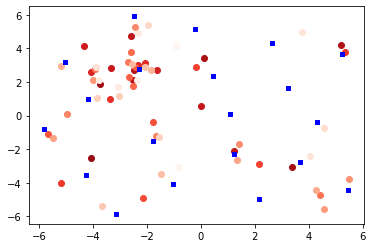

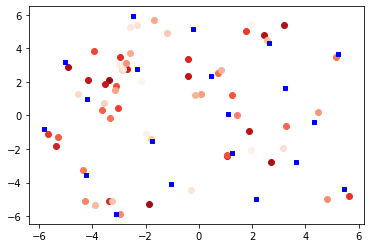

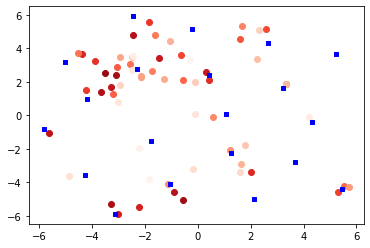

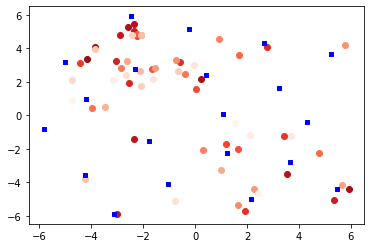

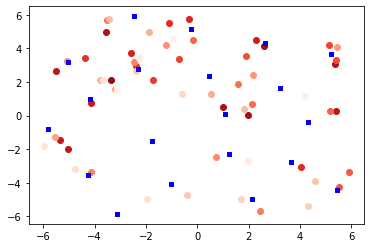

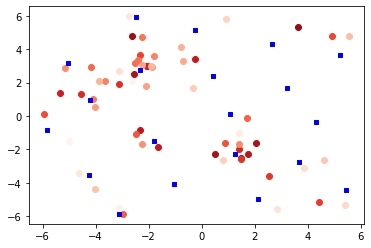

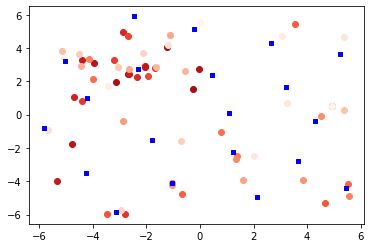

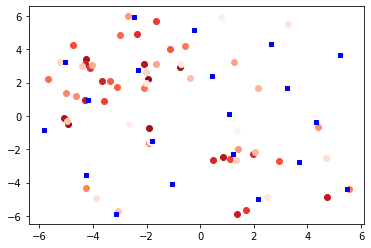

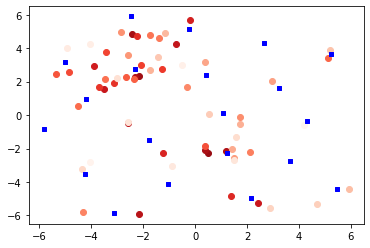

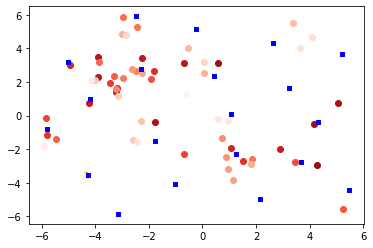

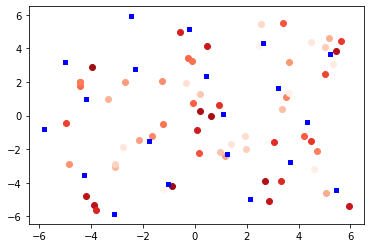

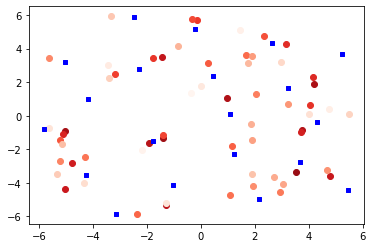

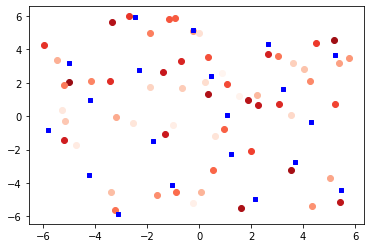

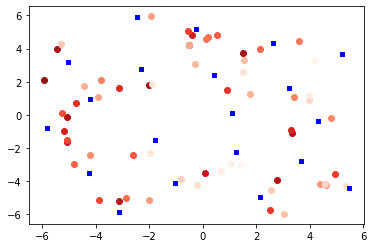

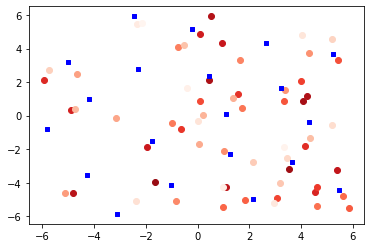

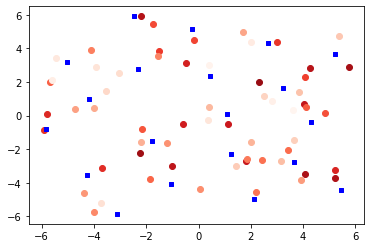

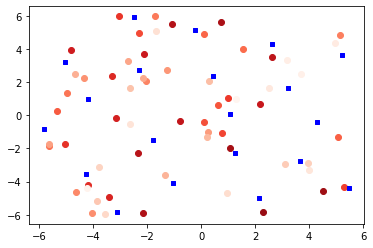

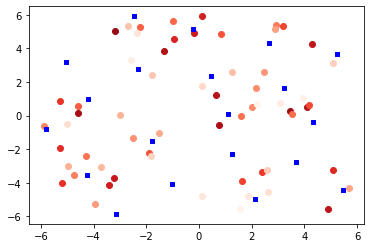

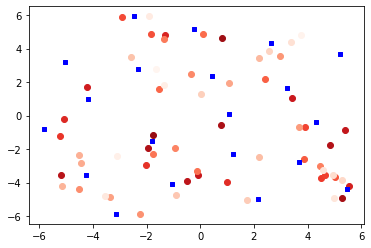

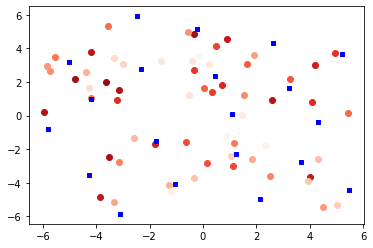

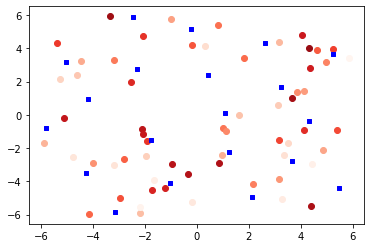

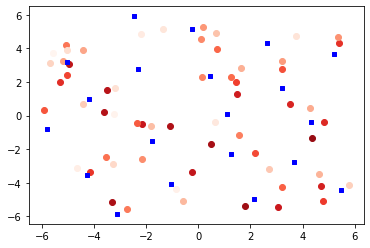

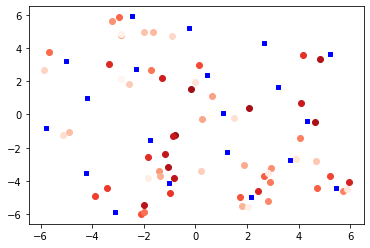

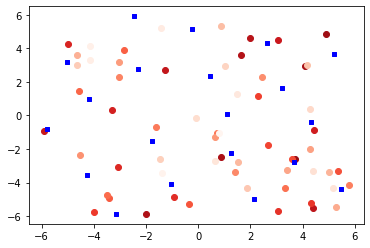

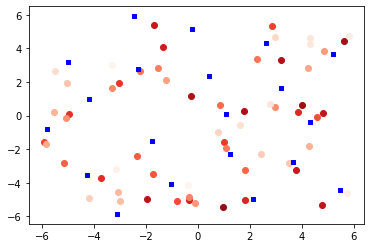

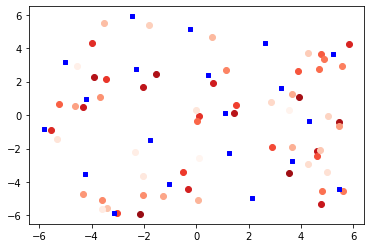

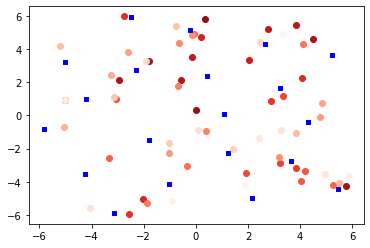

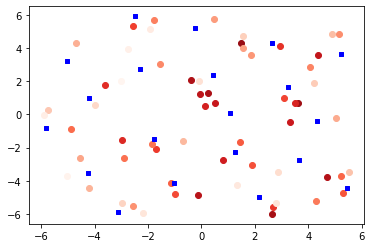

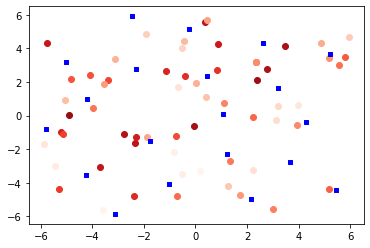

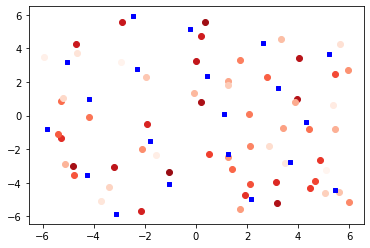

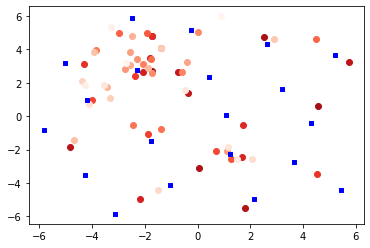

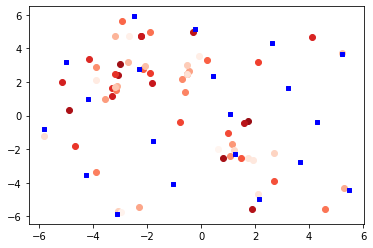

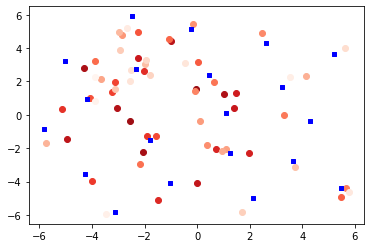

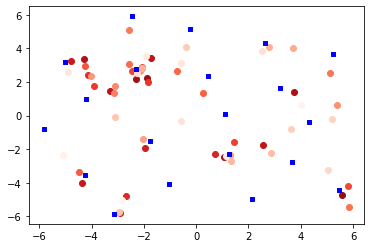

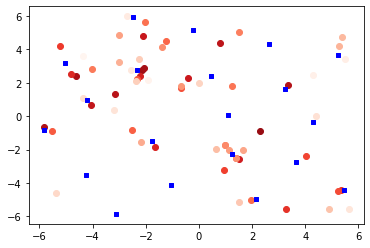

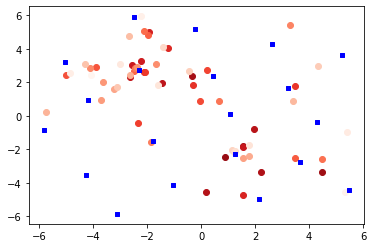

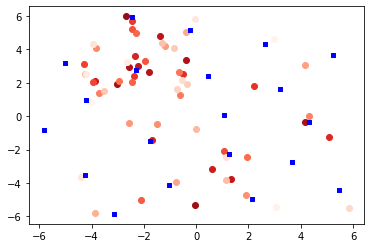

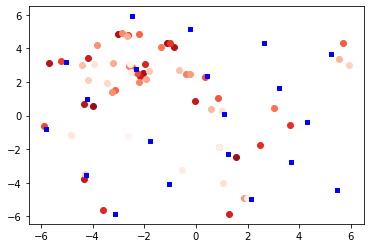

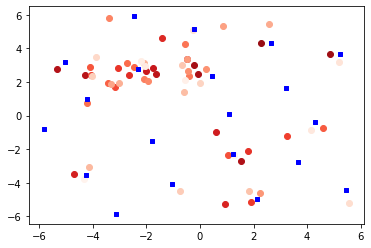

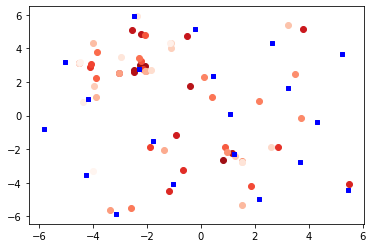

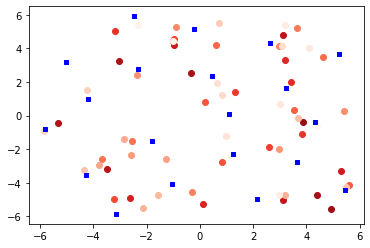

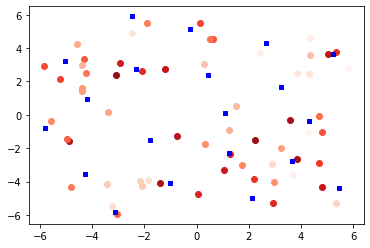

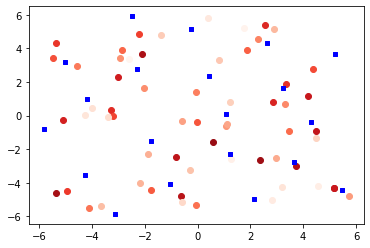

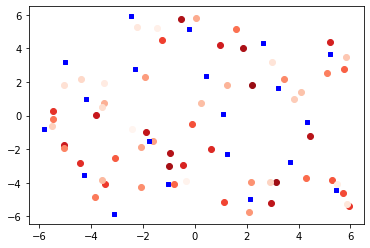

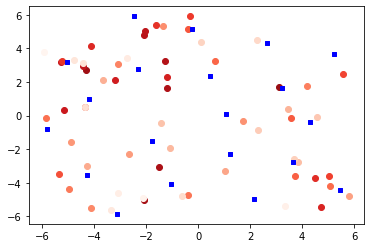

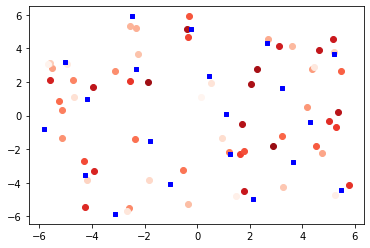

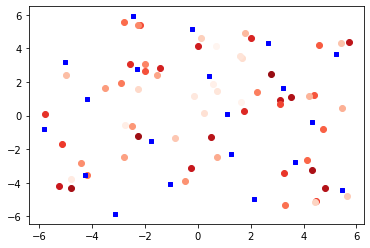

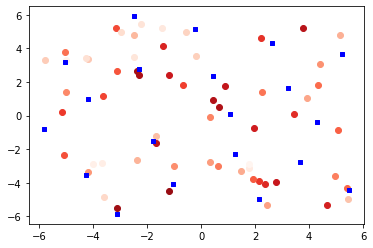

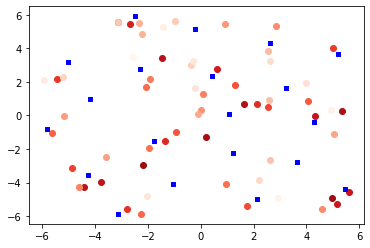

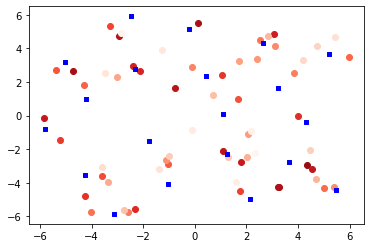

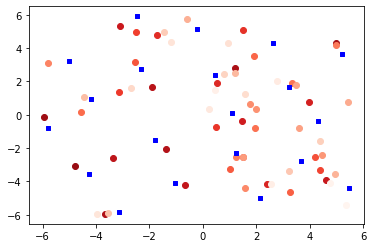

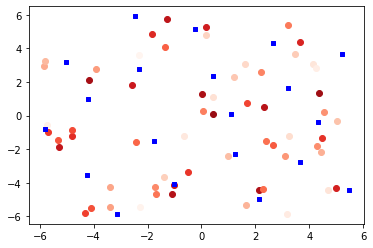

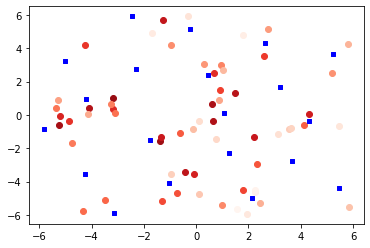

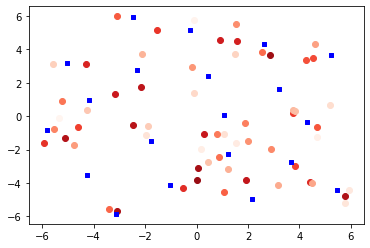

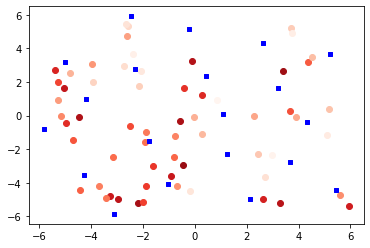

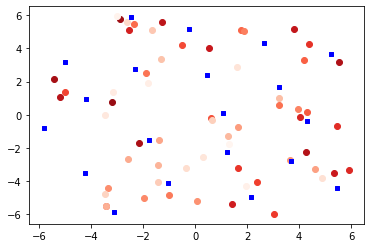

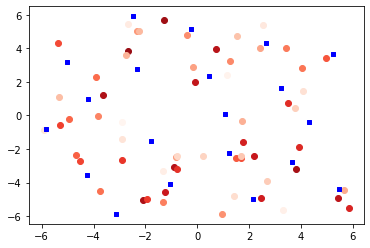

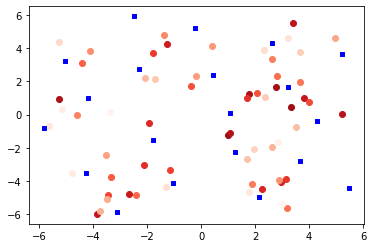

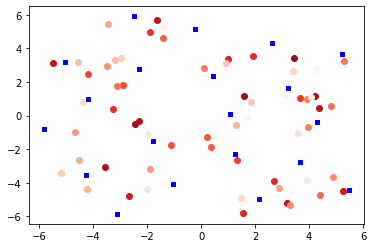

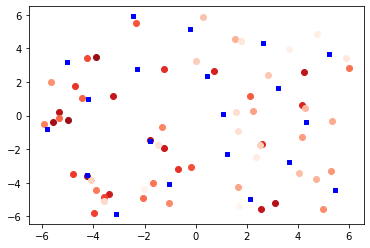

In [10]:
run(0.2,3,'var','D:\\Active-learning\\GLQ_B0.2_C3_maxvar.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.2,3,'probability','D:\\Active-learning\\GLQ_B0.2_C3_prob.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.2,3,'p_root','D:\\Active-learning\\GLQ_B0.2_C3_root.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.2,5,'var','D:\\Active-learning\\GLQ_B0.2_C5_maxvar.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.2,5,'probability','D:\\Active-learning\\GLQ_B0.2_C5_prob.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.2,5,'p_root','D:\\Active-learning\\GLQ_B0.2_C5_root.txt','D:\\Active-learning\\GLQ_LOSS.txt')

total points: 81           r2: 0.6874076312752717           rmse:  0.018989898937977166
total points: 81           r2: 0.5163490245819727           rmse:  0.02362106647136266
total points: 81           r2: 0.7418422282839084           rmse:  0.01725742798114215
total points: 81           r2: 0.6744164228501595           rmse:  0.01938048820474535
total points: 81           r2: 0.4140796505145037           rmse:  0.025998767400497103
total points: 81           r2: 0.3693704594755284           rmse:  0.02697246405544606
total points: 81           r2: 0.8349334349050207           rmse:  0.013799489640783426
total points: 81           r2: 0.5050716644103657           rmse:  0.023894867525659346
total points: 81           r2: 0.6577341995421295           rmse:  0.0198707939901385
total points: 81           r2: 0.4121188361109551           rmse:  0.026042234211350917
0    0.025267
1    0.000019
dtype: float64
0    0.581332
1    0.021583
dtype: float64
0:31:05.451408
total points: 81         

total points: 81           r2: 0.21823282227665763           rmse:  0.030031165276982477
total points: 81           r2: 0.5426886409988205           rmse:  0.02296886113796372
total points: 81           r2: -0.20211237953195527           rmse:  0.03723968532675802
total points: 81           r2: 0.37592011189013474           rmse:  0.026832031880730838
total points: 81           r2: 0.16310999555203953           rmse:  0.031071889099500677
total points: 81           r2: 0.16350192203943337           rmse:  0.031064612562328803
0    0.206804
1    0.000066
dtype: float64
0    0.215455
1    0.029087
dtype: float64
0:32:24.760813


,0,1
0,0.553389,0.022699
1,-0.841845,0.046096
2,0.722551,0.017891
3,0.459109,0.024980
4,0.218233,0.030031
5,0.542689,0.022969
6,-0.202112,0.037240
7,0.375920,0.026832
8,0.163110,0.031072
9,0.163502,0.031065


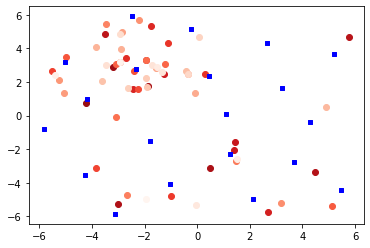

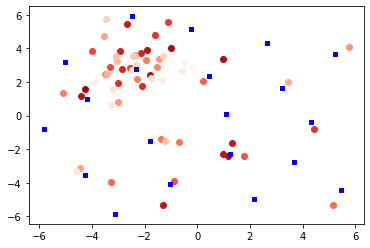

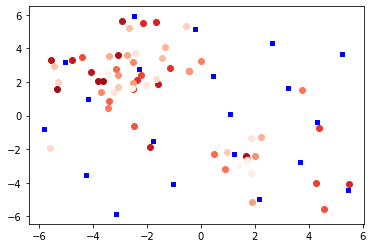

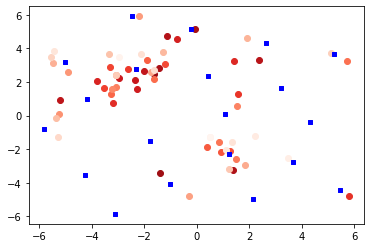

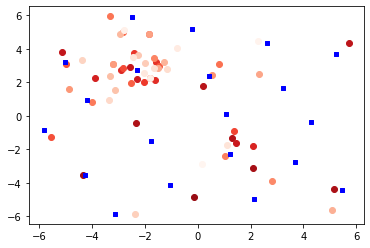

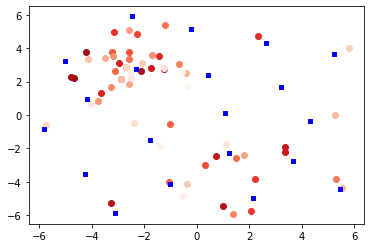

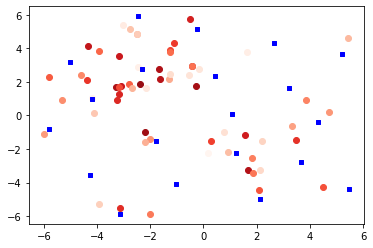

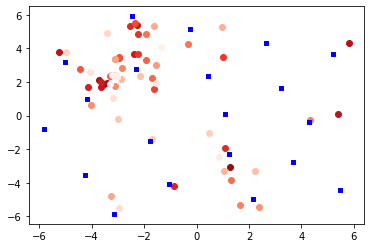

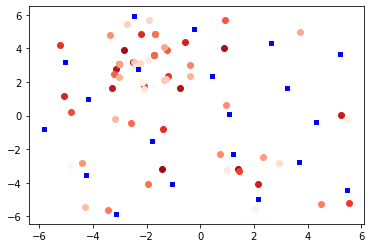

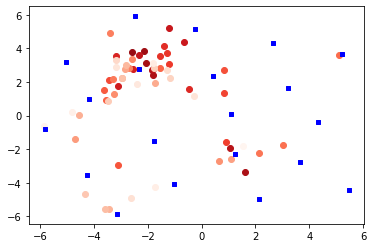

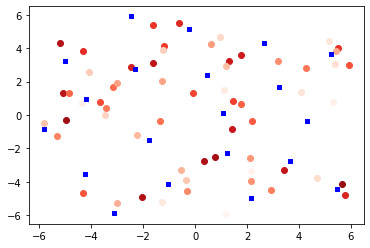

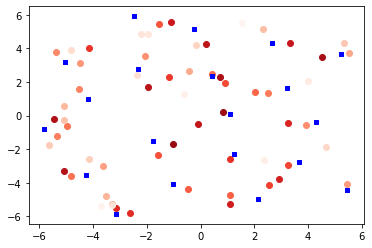

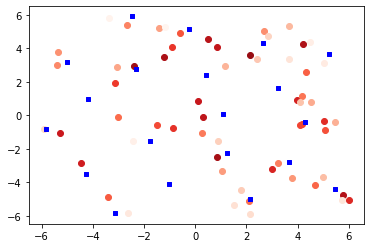

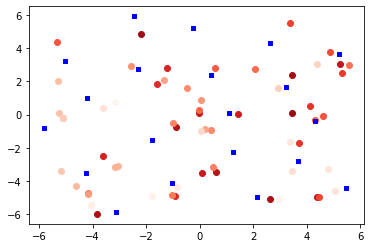

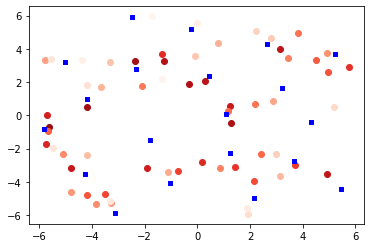

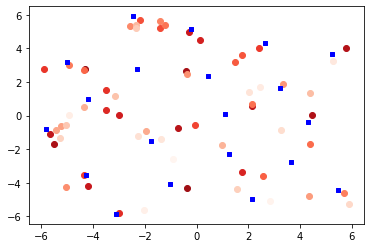

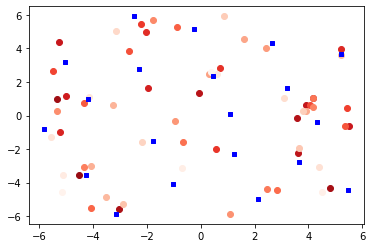

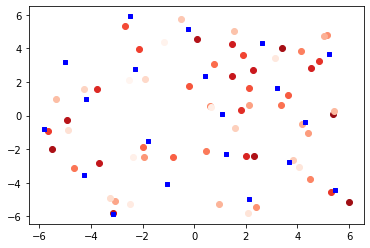

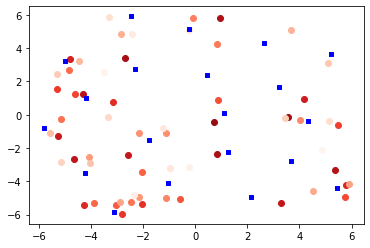

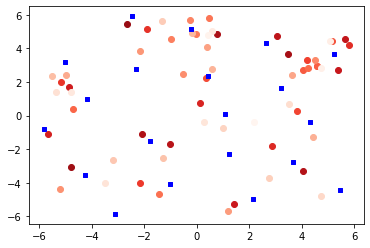

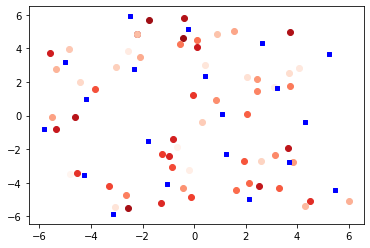

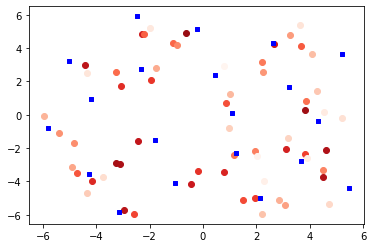

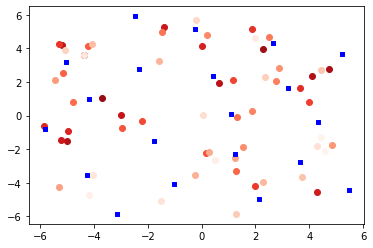

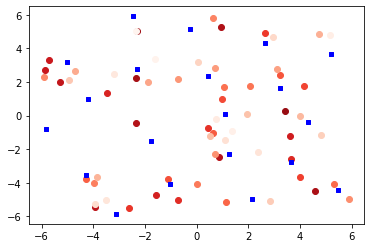

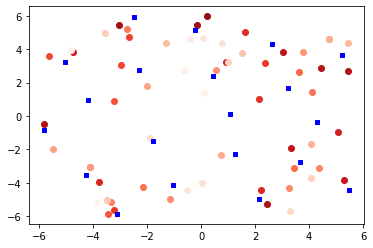

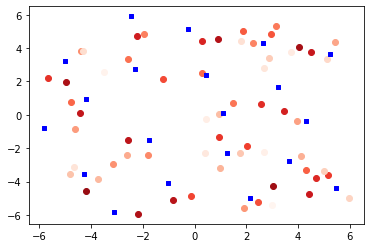

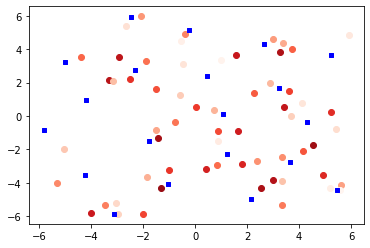

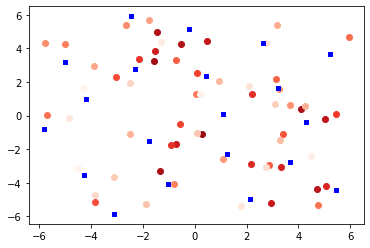

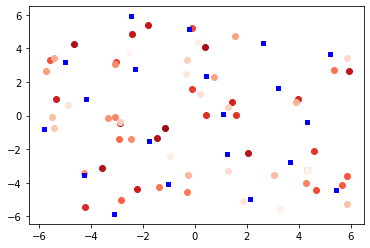

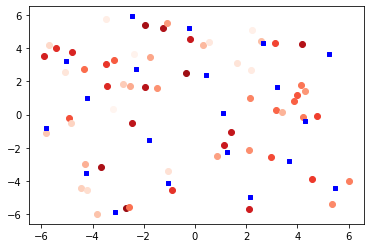

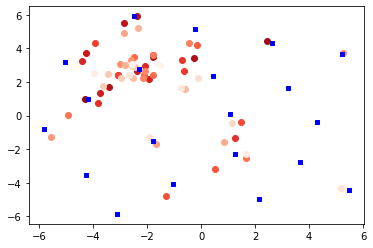

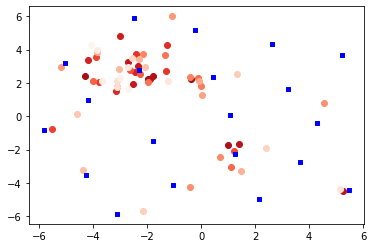

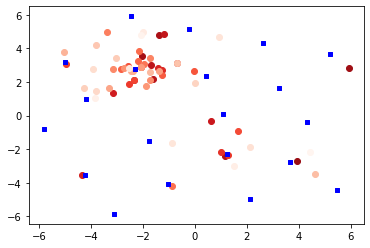

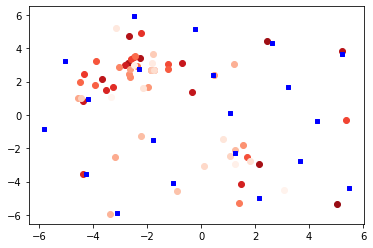

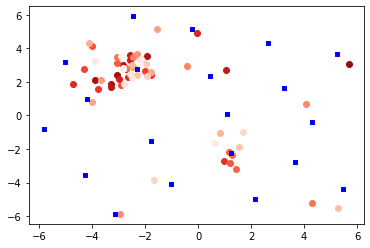

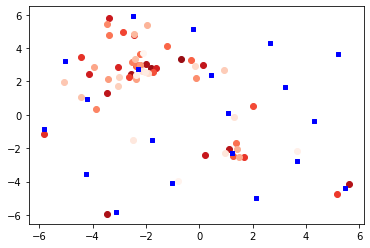

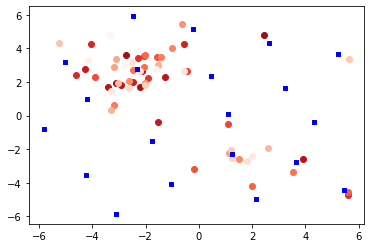

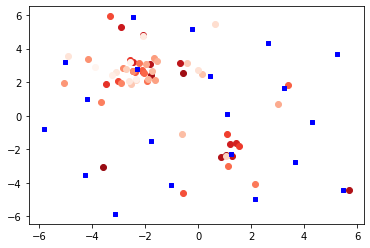

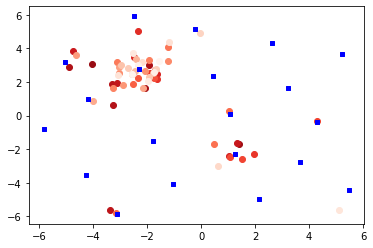

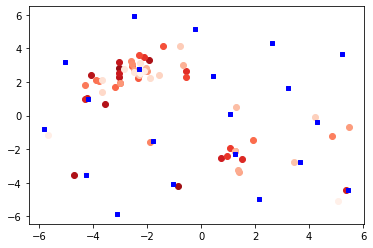

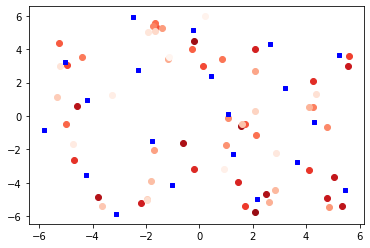

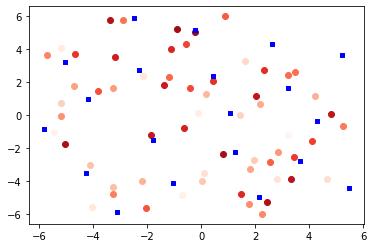

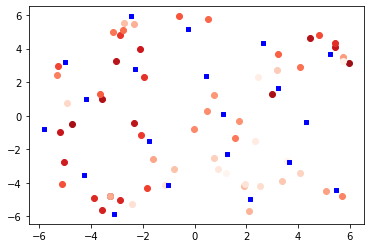

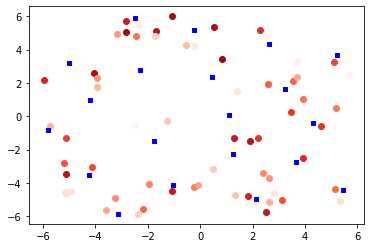

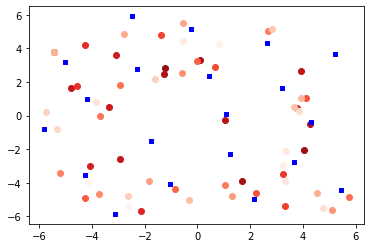

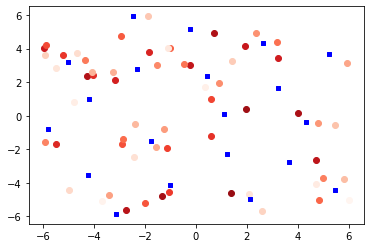

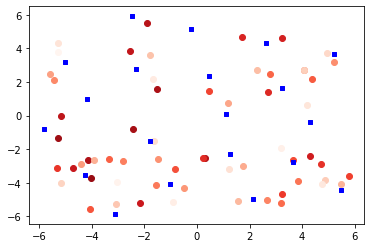

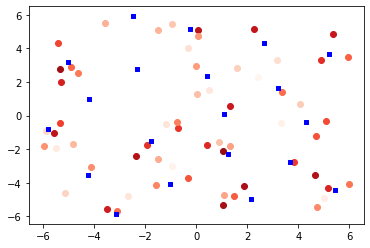

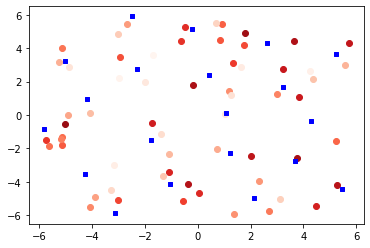

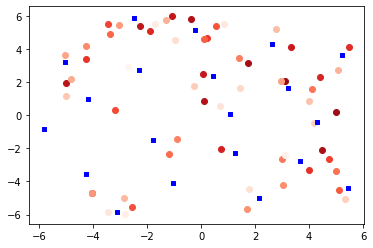

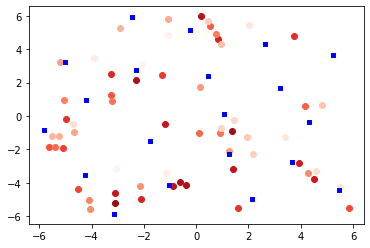

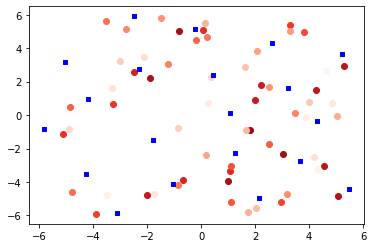

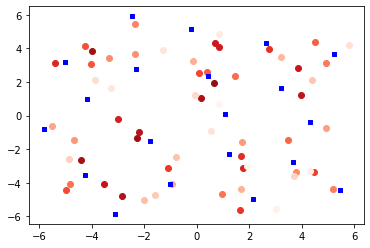

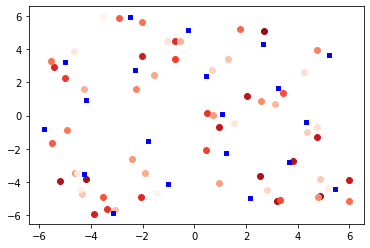

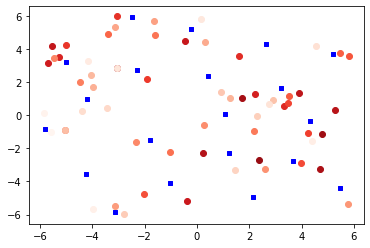

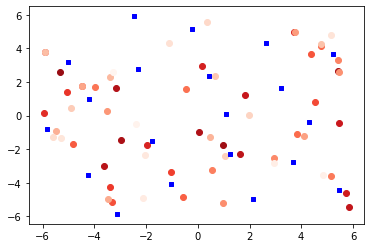

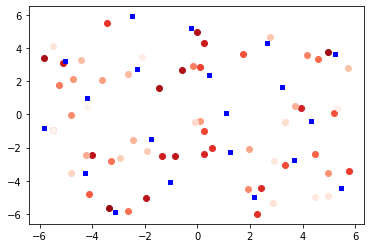

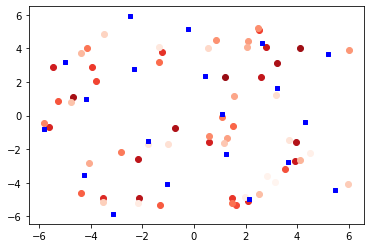

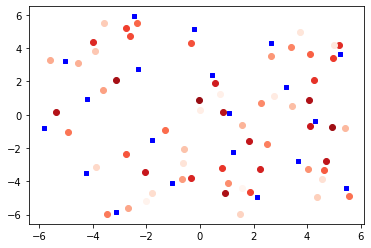

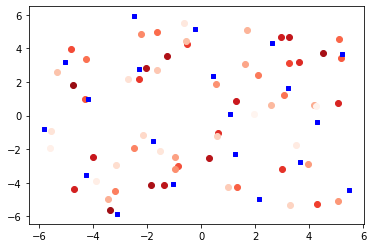

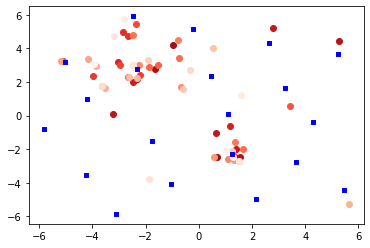

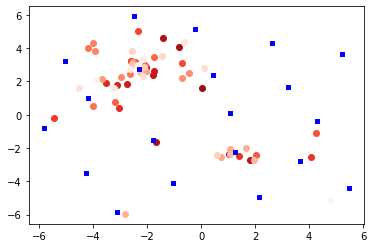

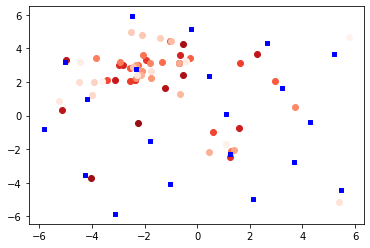

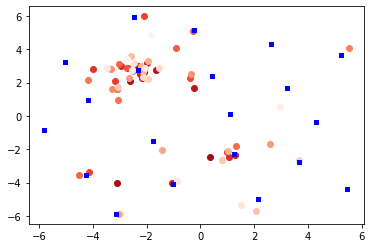

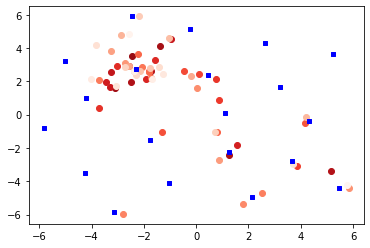

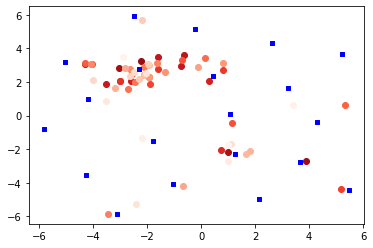

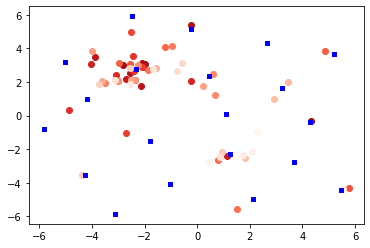

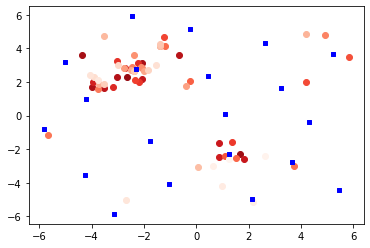

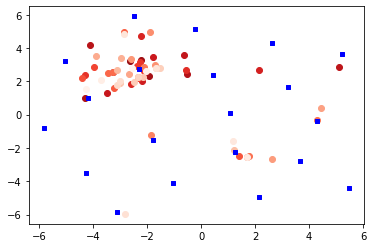

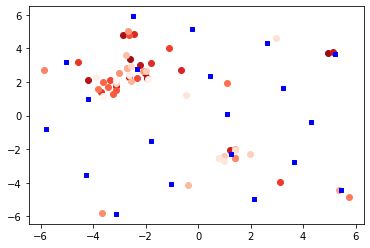

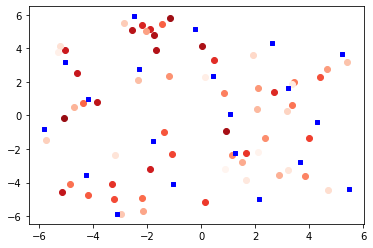

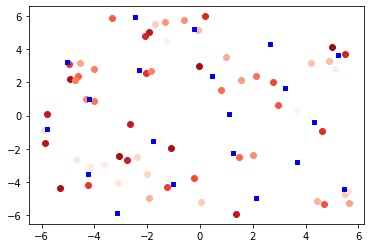

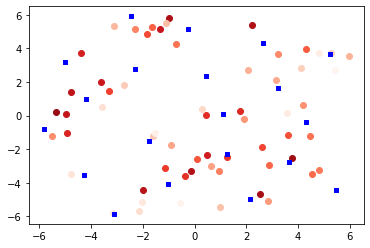

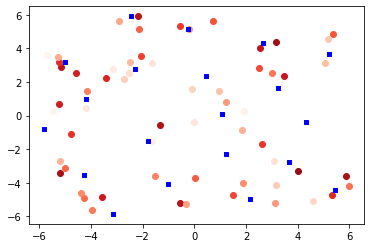

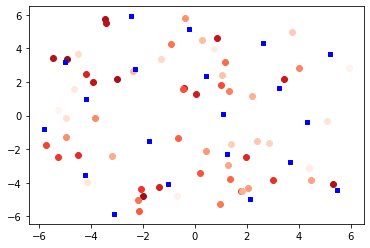

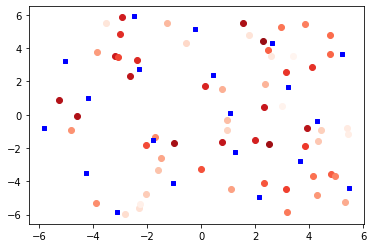

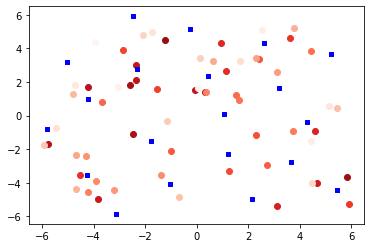

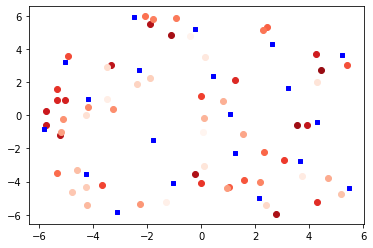

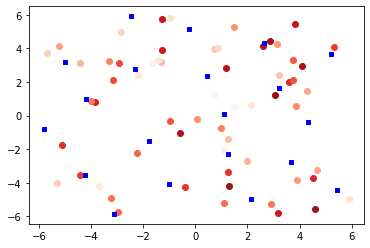

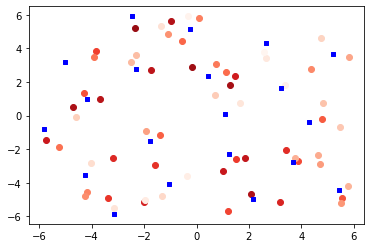

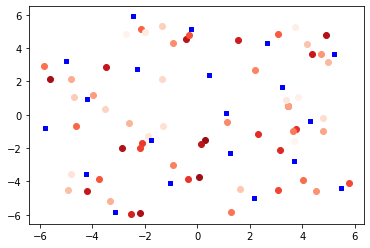

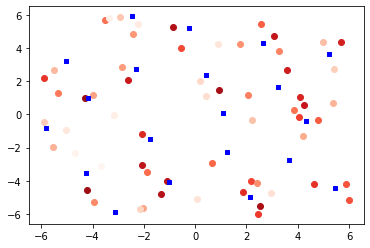

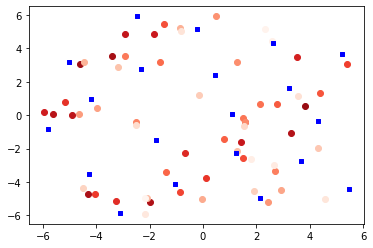

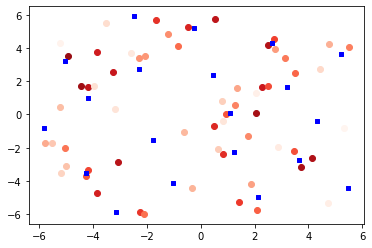

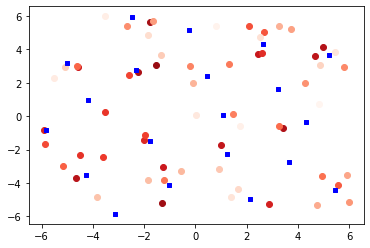

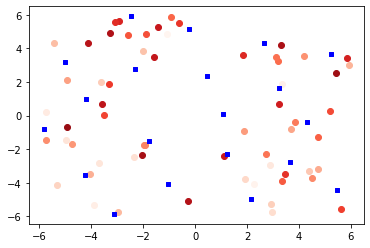

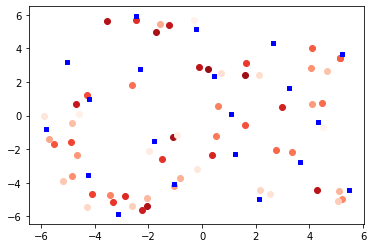

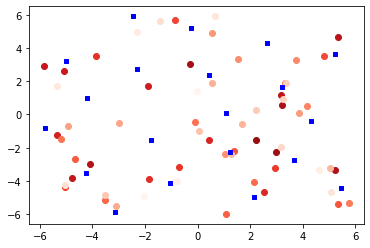

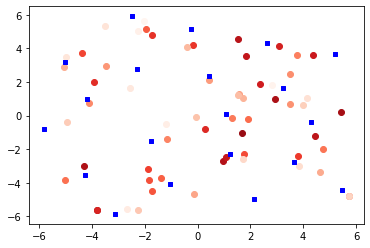

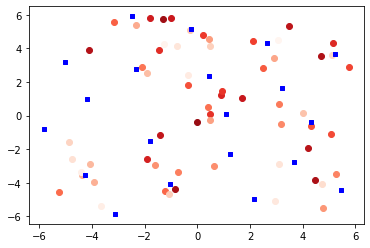

In [11]:
run(0.5,1,'var','D:\\Active-learning\\GLQ_B0.5_C1_maxvar.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.5,1,'probability','D:\\Active-learning\\GLQ_B0.5_C1_prob.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.5,1,'p_root','D:\\Active-learning\\GLQ_B0.5_C1_root.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.5,3,'var','D:\\Active-learning\\GLQ_B0.5_C3_maxvar.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.5,3,'probability','D:\\Active-learning\\GLQ_B0.5_C3_prob.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.5,3,'p_root','D:\\Active-learning\\GLQ_B0.5_C3_root.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.5,5,'var','D:\\Active-learning\\GLQ_B0.5_C5_maxvar.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.5,5,'probability','D:\\Active-learning\\GLQ_B0.5_C5_prob.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(0.5,5,'p_root','D:\\Active-learning\\GLQ_B0.5_C5_root.txt','D:\\Active-learning\\GLQ_LOSS.txt')

total points: 81           r2: -0.7033885635449046           rmse:  0.04432924466228519
total points: 81           r2: 0.04640784000919129           rmse:  0.033167657772588496
total points: 81           r2: -0.27034869761678904           rmse:  0.03828202839877155
total points: 81           r2: 0.06399769248513798           rmse:  0.0328603305246289
total points: 81           r2: 0.6509345844547039           rmse:  0.020067204610316306
total points: 81           r2: 0.16540288708265782           rmse:  0.03102929488973469
total points: 81           r2: 0.5806330046805639           rmse:  0.02199533555020347
total points: 81           r2: 0.4063703610689915           rmse:  0.026169248785573595
total points: 81           r2: -0.3924510482541774           rmse:  0.0400796052993809
total points: 81           r2: 0.45115997228577376           rmse:  0.025162648825394516
0    0.198362
1    0.000064
dtype: float64
0    0.099872
1    0.031314
dtype: float64
0:31:33.150082
total points: 81   

total points: 81           r2: -0.08057742867718631           rmse:  0.035307048455110825
total points: 81           r2: -0.5717359062611878           rmse:  0.0425817254164456
total points: 81           r2: 0.49376608327455207           rmse:  0.02416624016005751
total points: 81           r2: 0.5344527216667756           rmse:  0.023174766325006063
total points: 81           r2: 0.5254567641743266           rmse:  0.023397602656706075
0    0.175101
1    0.000069
dtype: float64
0    0.200380
1    0.029337
dtype: float64
0:33:16.766424


,0,1
0,0.158521,0.031157
1,-0.252453,0.038011
2,0.820051,0.014408
3,0.244539,0.029522
4,0.131781,0.031648
5,-0.080577,0.035307
6,-0.571736,0.042582
7,0.493766,0.024166
8,0.534453,0.023175
9,0.525457,0.023398


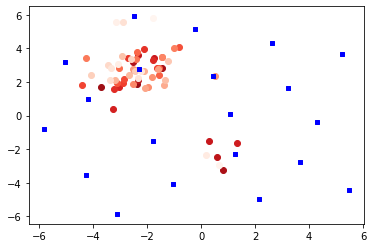

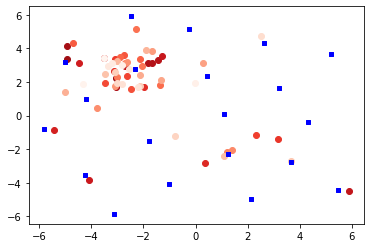

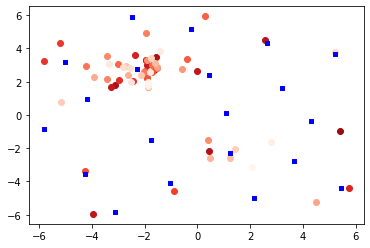

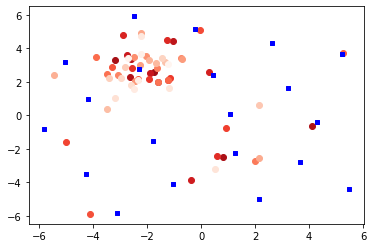

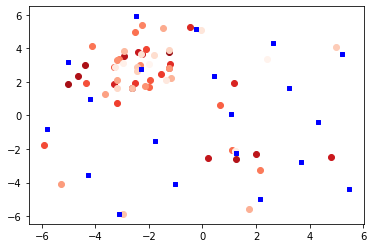

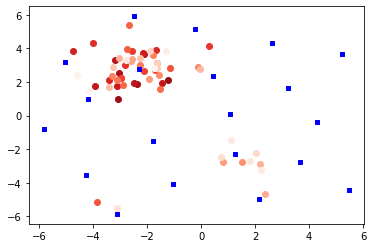

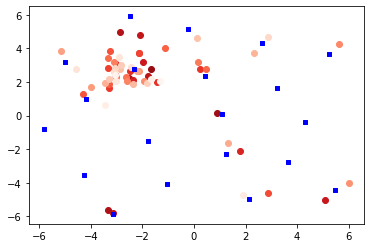

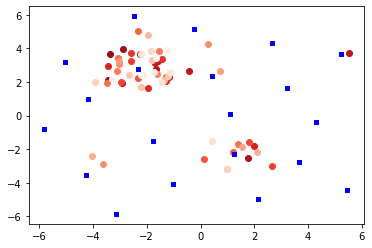

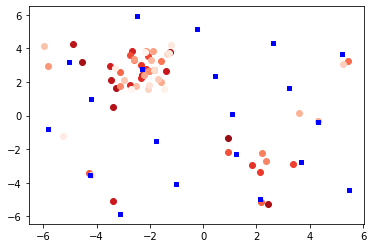

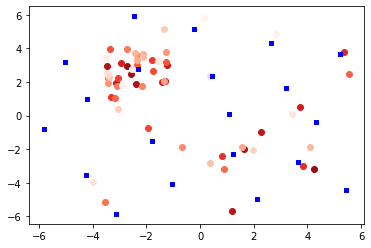

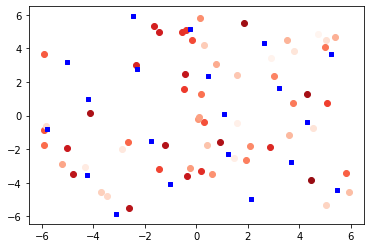

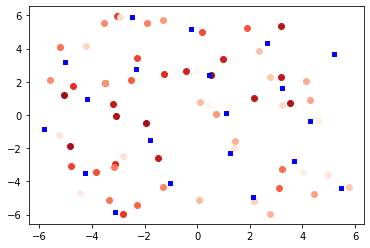

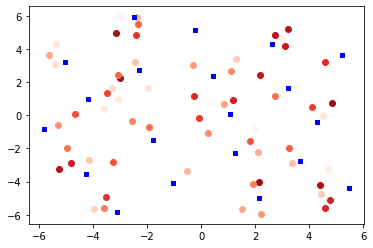

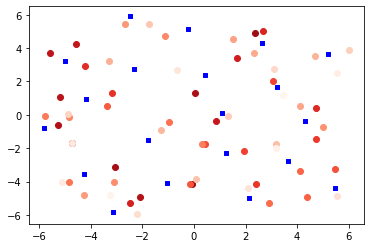

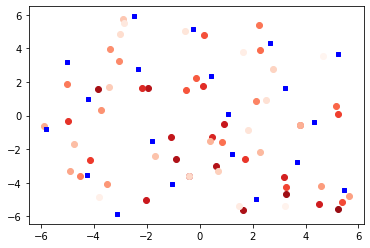

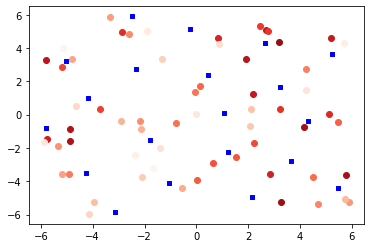

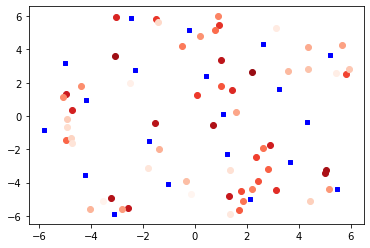

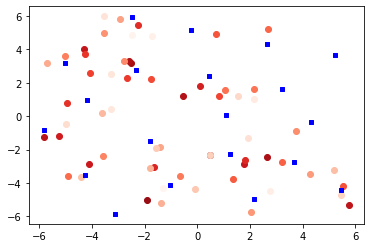

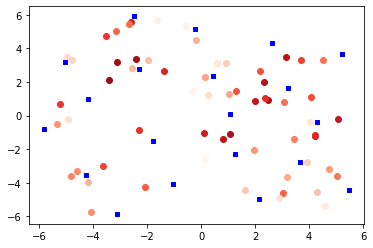

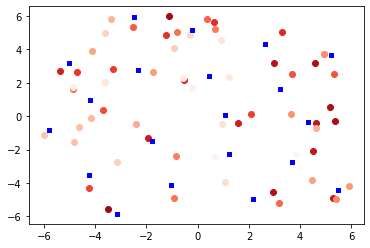

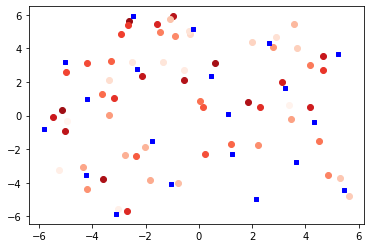

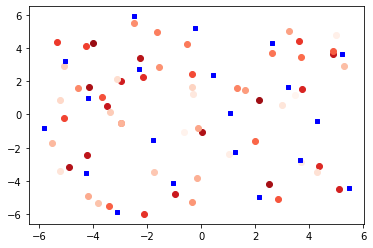

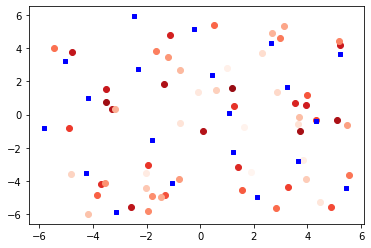

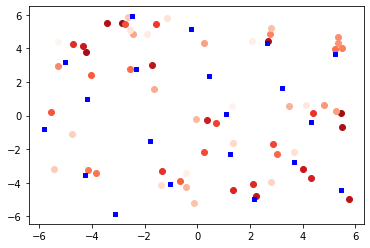

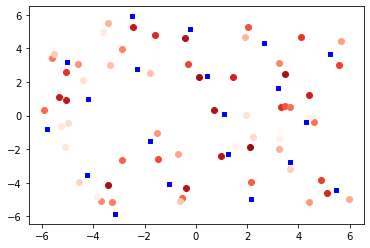

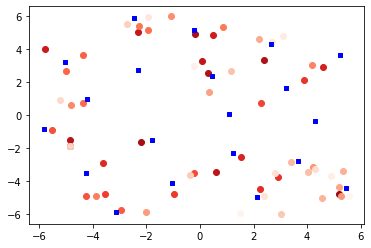

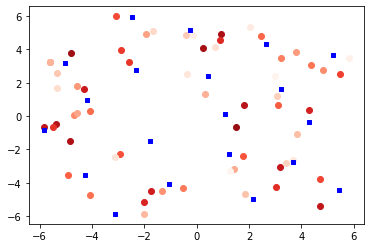

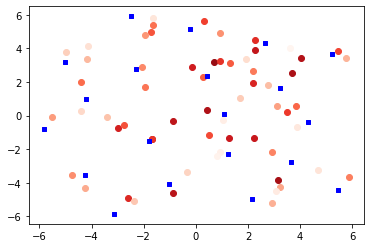

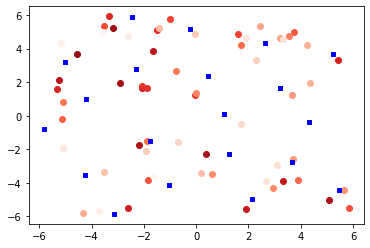

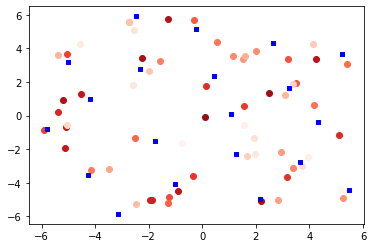

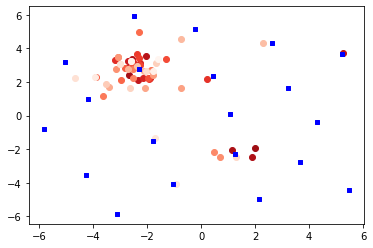

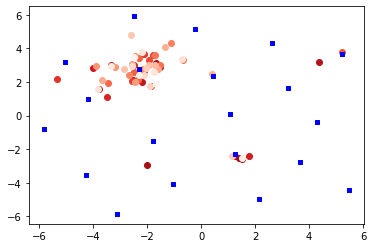

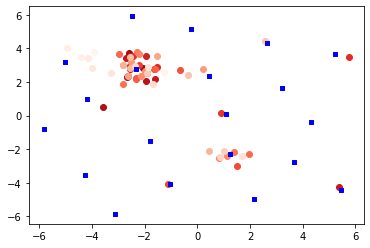

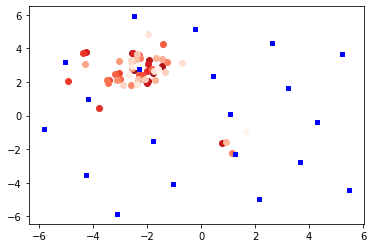

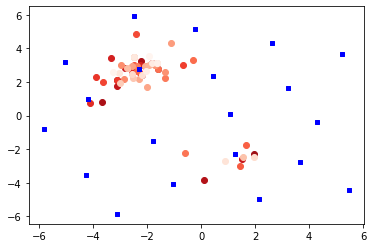

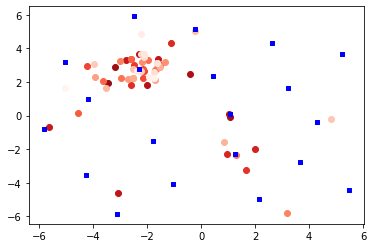

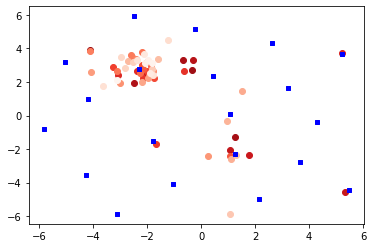

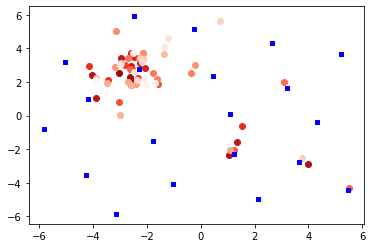

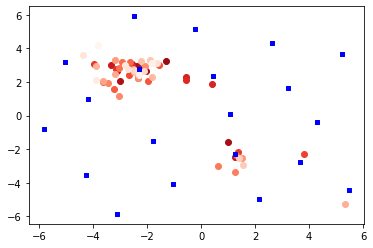

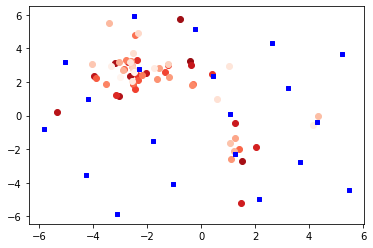

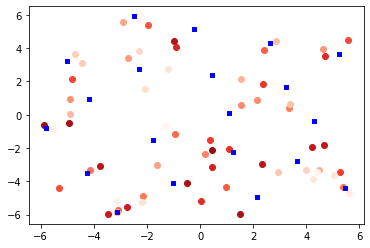

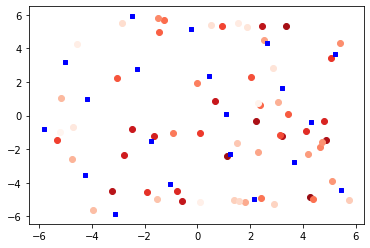

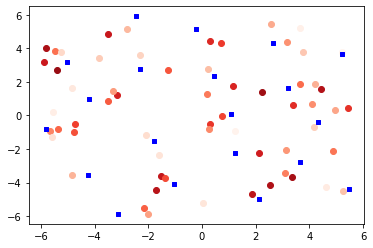

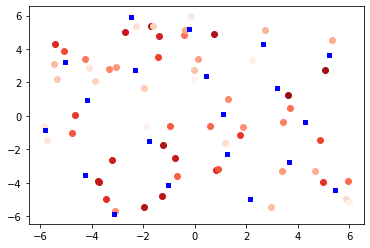

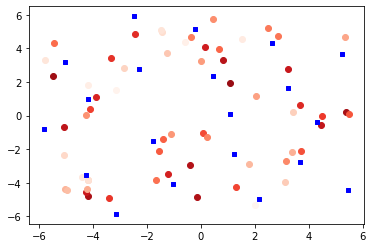

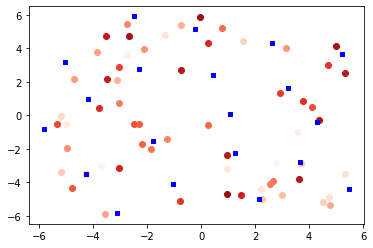

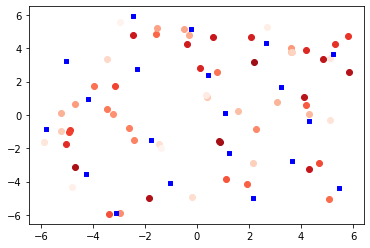

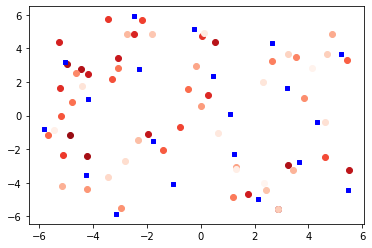

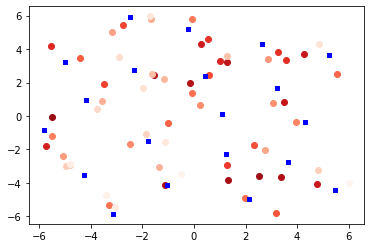

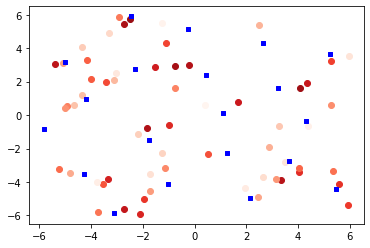

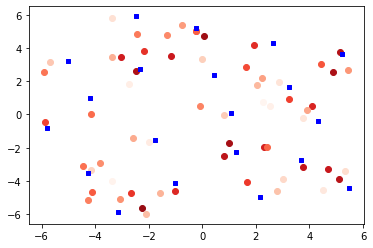

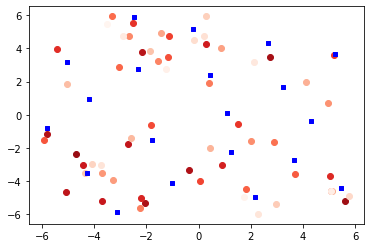

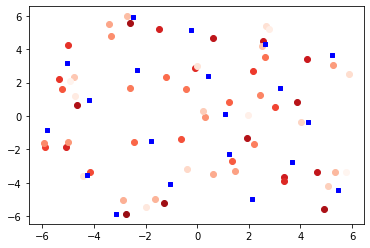

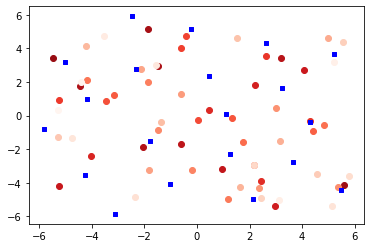

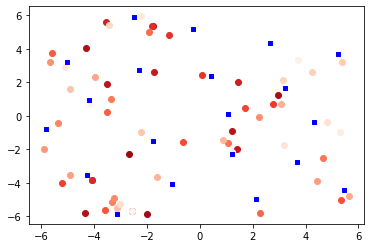

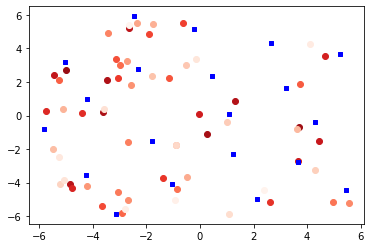

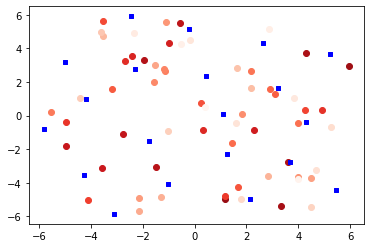

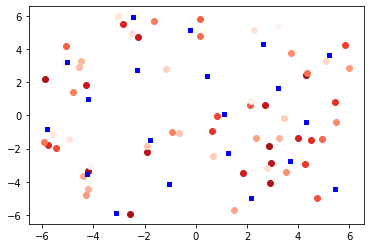

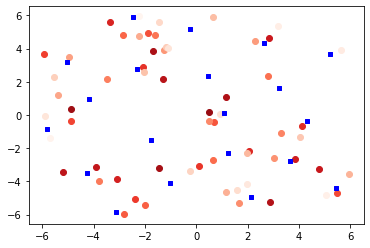

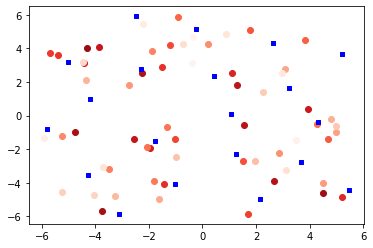

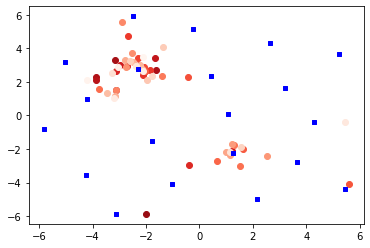

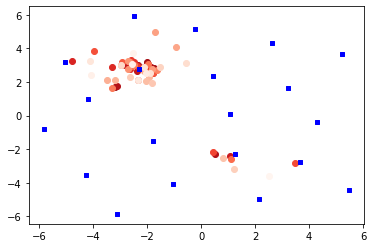

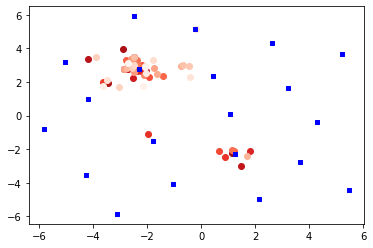

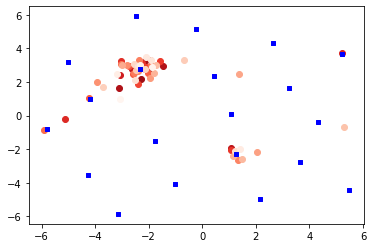

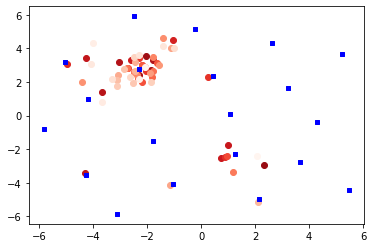

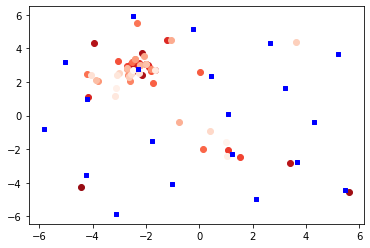

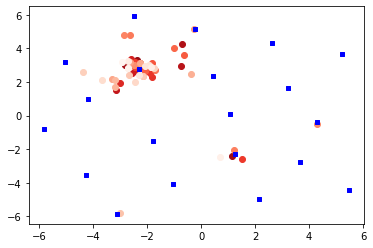

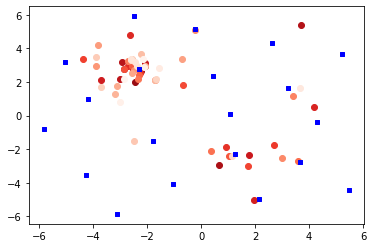

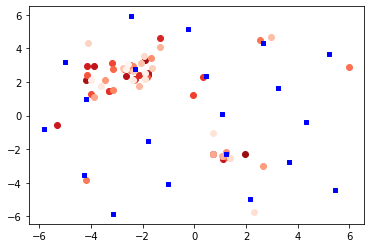

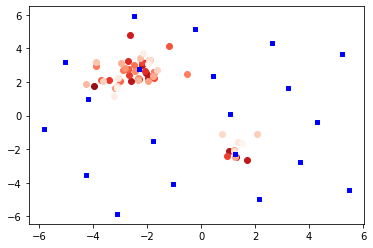

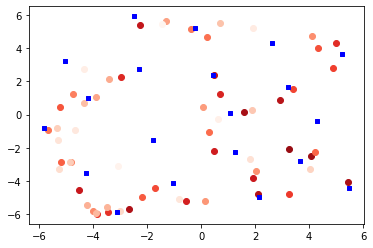

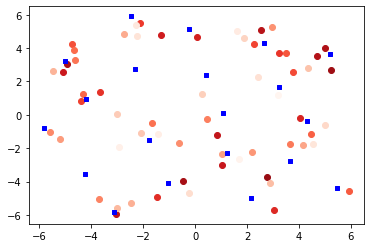

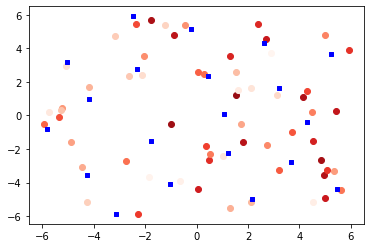

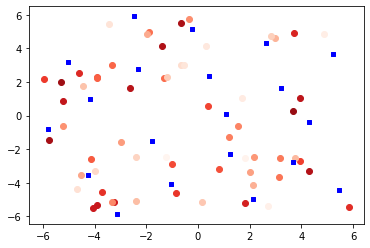

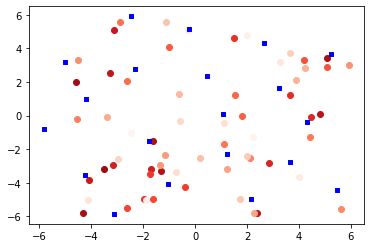

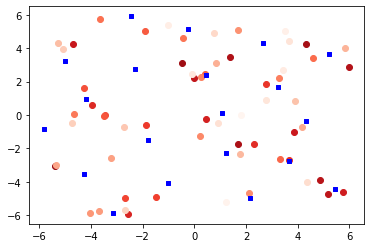

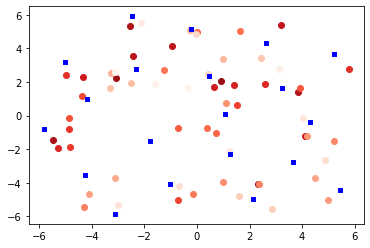

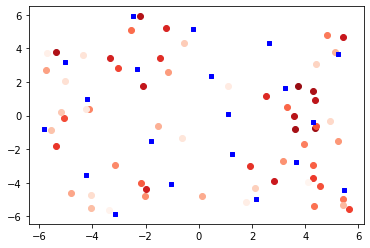

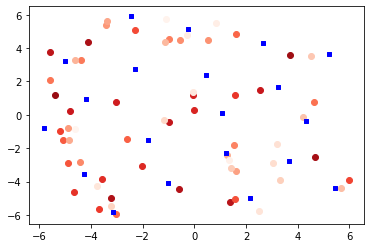

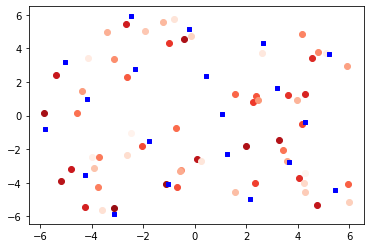

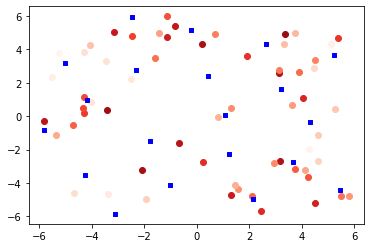

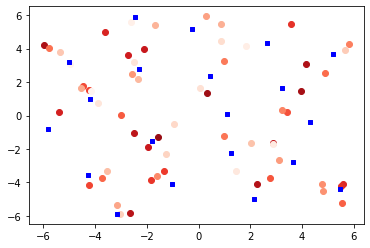

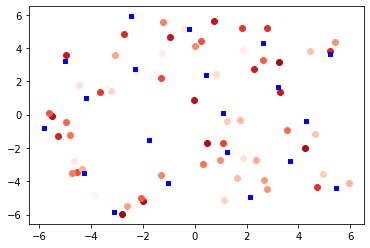

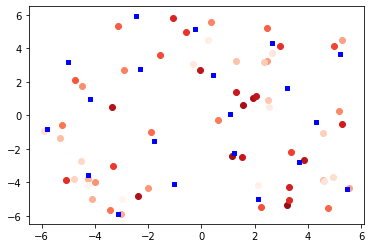

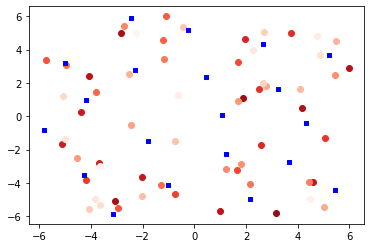

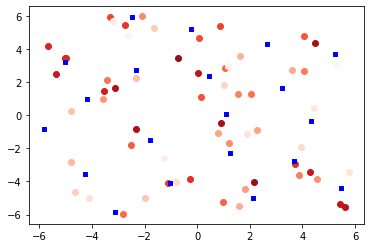

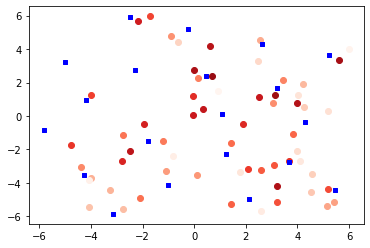

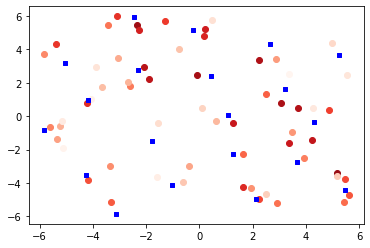

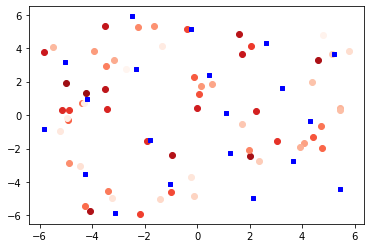

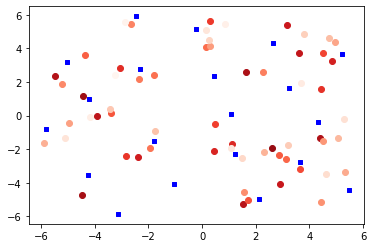

In [12]:
run(1,1,'var','D:\\Active-learning\\GLQ_B1_C1_maxvar.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(1,1,'probability','D:\\Active-learning\\GLQ_B1_C1_prob.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(1,1,'p_root','D:\\Active-learning\\GLQ_B1_C1_root.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(1,3,'var','D:\\Active-learning\\GLQ_B1_C3_maxvar.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(1,3,'probability','D:\\Active-learning\\GLQ_B1_C3_prob.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(1,3,'p_root','D:\\Active-learning\\GLQ_B1_C3_root.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(1,5,'var','D:\\Active-learning\\GLQ_B1_C5_maxvar.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(1,5,'probability','D:\\Active-learning\\GLQ_B1_C5_prob.txt','D:\\Active-learning\\GLQ_LOSS.txt')
run(1,5,'p_root','D:\\Active-learning\\GLQ_B1_C5_root.txt','D:\\Active-learning\\GLQ_LOSS.txt')